# **consensus_construction**

Python script to calculate consensus sequences by barcode.

For additional details, please refer to the GitHub repository: https://github.com/RTlabCBM/FidelityFinder

In [ ]:
#@markdown # Upload your FASTA file
#@markdown - The input must be a fasta file with the sequences where you want to find barcodes and build consensus sequences
from google.colab import files
uploaded = files.upload()
fasta_file = list(uploaded.keys())[0]

Saving Test_lengths_and_qual_filtered.fasta to Test_lengths_and_qual_filtered.fasta


In [ ]:
#@markdown # Input parameters
#@markdown
#@markdown - **reference sequence** (i.e., sequence of the insert of the library)  (each position of the barcode must be indicated with "N")
reference = 'CAGGAGCCGATAGACAAGGAACTGTATCCTTTAACTTCCCTCAGATGGATCCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAATGGATGGCCCAAAAGTTAAACTGNNNNNNNNNNNNGAAGAG' #@param {type:"string"}
#@markdown - **upper cut-off** of sequences per barcode (barcodes with this frequency or higher will not be used to build consensus sequences)
superior = 1000000 # @param {type:"integer"}
#@markdown - **lower cut-off** of sequences per barcode (barcodes with this frequency or lower will not be used to build consensus sequences)
inferior = 2 # @param {type:"integer"}
#@markdown - **threshold percentage(s)** (integers) to construct consensus sequences. (range 0 - 100, default: 90). Provide as a comma-separated list.
#@markdown  - For example, with a threshold of 50, a nucleotide must be present in at least 50% of the sequences that share a barcode to appear in the consensus sequence; otherwise, an N (indeterminate base) will be used
threshold_consensus_list = 90,70,50 # @param {type:"string"}
#@markdown - **Prefix** used in the name of output files generated
output_prefix = "undefined" #@param {type:"string"}









#examples of insert sequences:
#CTTCCTACAAGGGAAGGCCAGGGAATTTTCTTCAGAGCAGACCAGAGCCAACAGCCCCACCAGAAGAGAGCTTCAGGTCTGGGGTAGAGACAACAACTCCCCCTCAGAAGCAGGAGCCGATAGACAAGGAACTGTATCCTTTAACTTCCCTCAGATGGATCCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAATGGATGGCCCAAAAGTTAAACNNNNNNNNNNNNNNACCTT
#CAGGAGCCGATAGACAAGGAACTGTATCCTTTAACTTCCCTCAGATGGATCCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAATGGATGGCCCAAAAGTTAAACTGNNNNNNNNNNNNGAAGAG


	 ***************************************************************************

	Python script to calculate consensus sequences by barcode

	-. .-.   .-. .-.   .-. .-.   .-. .-.   .-. .-.   .-. .-.   .-. .-.   .
	  \   \ /   \   \ /   \   \ /   \   \ /   \   \ /   \   \ /   \   \ / 
	 / \   \   / \   \   / \   \   / \   \   / \   \   / \   \   / \   \  
	~   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-

	 *************************************************************************** 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.7 MB/s eta 0:00:00
Extracting templates from packages: 100%
Selecting previously unselected package fonts-lato.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../00-fonts-lato_2.0-2.1_all.deb ...
Unpacking fonts-lato (2.0-2.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unsel

227it [00:42,  5.31it/s]


		Total initial sequences:  227
		Accepted sequences:  227
		Rejected sequences (different barcode length):  0
		Rejected sequences (no alignment to the reference sequence):  0
		Barcodes lengths and their frequency:  {12: 227}
		Total unique barcodes with expected length found:  56
	Step 2 done

	Step 3 => Creating consensus_files | Creating dictionary with barcode frequencies


100%|██████████| 56/56 [00:03<00:00, 14.10it/s]


		Occurrences of each barcode frequency:  defaultdict(<class 'int'>, {1: 34, 2: 9, 10: 2, 26: 1, 40: 1, 8: 1, 3: 4, 14: 1, 42: 1, 4: 1, 9: 1})
		Total number of consensus sequences constructed (using 2 as inferior cutoff value):  56
	Step 3 done

	Step 4 => Drawing graph


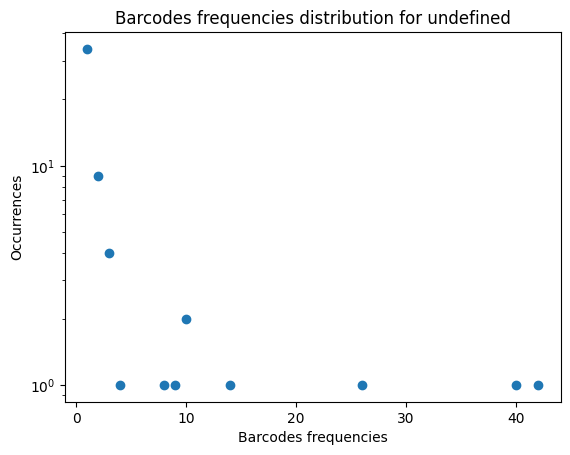

	Step 4 done

2
	JOB DONE !!! Have a nice & pythonic day!!! (^_^)



In [ ]:
#@markdown # Main program
__file__ = "main_program"

!pip install biopython==1.81
!apt-get install -qq -y mafft=7.490-1


# encoding: UTF-8

########################################################################################
print()
print("\t", "*" * 75)
print()
print("\tPython script to calculate consensus sequences by barcode")
print()
print("\t-. .-.   .-. .-.   .-. .-.   .-. .-.   .-. .-.   .-. .-.   .-. .-.   .")
print("\t  \   \ /   \   \ /   \   \ /   \   \ /   \   \ /   \   \ /   \   \ / ")
print("\t / \   \   / \   \   / \   \   / \   \   / \   \   / \   \   / \   \  ")
print("\t~   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-`   `-~ `-")
print()
print("\t", "*" * 75, "\n")
########################################################################################



__doc__ = """
SYNOPSIS

 Python script to calculate consensus sequences by barcode

 This script is an adaptation of the original program to be run on Google Colab.

DESCRIPTION

 Parameters. These variables are needed:
    fasta_file		              fasta file [required]
    reference                   reference sequence (i.e., sequence of the insert of the library) (each position of the barcode must be indicated with "N") [required]
    superior	                  upper cut-off of sequences per barcode (barcodes with this frequency or higher will not be used to build consensus sequences) [default=10000000]
    inferior	                  lower cut-off of sequences per barcode (barcodes with this frequency or lower will not be used to build consensus sequences) [default=4]
    threshold_consensus_list    threshold percentage(s) (integers) to construct consensus sequences (range 0 - 100, default: 90). Provide as a comma-separated list.
    output_prefix		            output prefix [default='undefined']

 Output files:
    - Consensus Sequences File(s) ({output_prefix}_t{threshold_consensus}_consensus.fna):
        FASTA file(s) with consensus sequences for unique barcodes. The number of files depends on the number of threshold_values provided in threshold_consensus_list
    - Profiles File ({output_prefix}_consensus.prf):
        Text file containing position-specific score matrices for barcode consensus sequences.
    - Barcodes JSON File ({output_prefix}_barcodes.json):
        JSON file mapping barcodes to the number of associated sequences.
    - Discarded Sequences File ({output_prefix}_discarded.txt):
        Text file with information on discarded sequences (sequences (sequences whose barcode has a frequency that is not within the inferior and superior values defined).
    - Graphical Plot ({output_prefix}_consensus.png):
        Scatter plot illustrating the distribution of raw sequence reads per unique primer ID.

  Note: This script was tested using Biopython version 1.81 and mafft 7.490. You can install them by running:
    pip install biopython==1.81
    apt-get install -qq -y mafft=7.490-1


AUTHORS

    This is a script modified by Javier Martinez del Río (javier.martinez@cbm.csic.es; javier.mardelrio@gmail.com) and
    Estrella Frutos-Beltrán (efrutos@cbm.csic.es) from the version 1 of the script created
    by the following authors:

    Genomics & NGS Facility (CBMSO-CSIC) | Eva Castillo    <ecastillo@cbm.csic.es>
                                         | Eva Sacristán  <esacristan@cbm.csic.es>
                                         | Sandra González  <sandra.g@cbm.csic.es>
                                         | Ramón Peiró-Pastor <rpeiro@cbm.csic.es>

LICENSE

    Copyright (c) 2018 CBMSO

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

__version__ = 'v2.0.0'



## Imports
##----------

import sys, os
import json
import seaborn as sbn
import matplotlib.pyplot as plt
from collections import defaultdict
from Bio import SeqIO
from Bio.Align.Applications import MafftCommandline
from io import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Align.AlignInfo import SummaryInfo

import multiprocessing
from tqdm import tqdm
%matplotlib inline

## Functions
##----------

def parse_threshold(input_threshold):
    """
    Parses the input string for threshold values and returns a list of integers.

    Parameters:
    - input_threshold (str): Input string containing threshold values separated by commas.

    Returns:
    - list of int: List of threshold values as integers.
    """
    try:
        # Try to convert the input string into a list of numbers
        threshold_list = [int(val) for val in input_threshold.split(',')]
        return threshold_list
    except ValueError:
        raise send_error_message(f"Invalid threshold format: {input_threshold}. Please provide a comma-separated list of integers.")

def send_error_message(message):
    """Gives an error message"""
    print("\n\t########## ERROR ########## \n{}\n".format(message))
    sys.exit(1)

def find_barcode(reference_sequence, query_sequence, cores):
    """
    Finds a barcode in the query_sequence using the reference_sequence.

    Parameters:
    - reference_sequence (str): The insert of the library sequenced, indicating each letter of the barcode zone as "N".
    - query_sequence (str): The raw sequence of the insert obtained by NGS.
    - cores (int): number of cores available

    Returns:
    - str: The identified barcode sequence.
    """
    mafft_cline = MafftCommandline("mafft", input="-", auto=True, thread=cores)
    stdout, stderr = mafft_cline(stdin=f">reference_sequence\n{reference_sequence}\n>query_sequence\n{query_sequence}")
    align = AlignIO.read(StringIO(stdout), "fasta")
    ref_aligned = str(align[0].seq)
    query_aligned = str(align[1].seq)
    # Select barcode sequence (it corresponds to the part of query_sequence that aligns with the letters "N" of reference_sequence):
    barcode = ""
    for ref_nuc, query_nuc in zip(ref_aligned, query_aligned):
        if ref_nuc == "n" and  query_nuc != "-":
            barcode += query_nuc
    return barcode

def process_fasta_file(reference_file, fasta_file, cores):
    """
    Process FASTA files and perform barcode search.

    Parameters:
    - reference_sequence (str): reference insert sequence
    - fasta_file (str): Path to the input FASTA file.
    - cores (int): Number of CPU cores to use.

    Returns:
    - fasta_dic: Dictionary containing barcodes as keys and corresponding sequences as values.
    """
    # Read input files
    reference_sequence = next(SeqIO.parse(reference_file, "fasta")).seq
    fasta_hand = SeqIO.parse(fasta_file, "fasta")

    #Calculate barcode size in the reference sequence
    bc_size = reference_sequence.lower().count('n')
    if bc_size < 1:
        send_error_message("No barcode could be found in the reference sequence provided\nPlease, check that the reference sequence contains at least one barcode (indicated with \"N\" characters in the positions of the barcode)")

    #Create fasta_dic
    fasta_dic = defaultdict(list)
    bc_lengths_dic = defaultdict(int)
    accepted_sequences = 0
    rejected_sequences_bc_size = 0
    rejected_sequences_no_align = 0
    for record in tqdm(fasta_hand):
      read = str(record.seq)
      try:
        barcode = find_barcode(reference_sequence, read, cores)
        bc_lengths_dic[len(barcode)] += 1
        if len(barcode) == bc_size:
            fasta_dic[barcode].append(read)
            accepted_sequences += 1
        else:
            rejected_sequences_bc_size += 1
      except Exception as e:
        rejected_sequences_no_align += 1
        print(e)

    # Check if any sequences were accepted
    if accepted_sequences < 1:
        send_error_message(f'No sequences could be found (sample: {output_prefix}), please check the input parameters of {__file__}\nHave you chosen the right input parameters?')

    # Print summary statistics
    print("\t\tTotal initial sequences: ", accepted_sequences + rejected_sequences_bc_size + rejected_sequences_no_align)
    print("\t\tAccepted sequences: ", accepted_sequences) #Number of sequences with the correct barcode size
    print("\t\tRejected sequences (different barcode length): ", rejected_sequences_bc_size) # Number of sequences with incorrect barcode size
    print("\t\tRejected sequences (no alignment to the reference sequence): ", rejected_sequences_no_align) # Number of sequences with no alignment
    print("\t\tBarcodes lengths and their frequency: ", dict(bc_lengths_dic)) #Dictionary containing barcode lengths as keys and counts as values
    print("\t\tTotal unique barcodes with expected length found: ", len(fasta_dic.keys()))

    return fasta_dic

def create_fasta_file(sequences_list):
    """Creates a fasta file using a list of sequences"""
    fasta_tmp = "tmp.fa"
    with open(fasta_tmp, "w") as tmp_hand:
        for counter, seq in enumerate(sequences_list):
            header = f">sequence_{counter}\n"
            tmp_hand.write(header + seq + "\n")
    return fasta_tmp

def align_sequences(sequences_list, cores):
    """Aligns sequences provided"""
    fasta_tmp = create_fasta_file(sequences_list)
    mafft_cline = MafftCommandline("mafft", input=fasta_tmp, thread=cores)
    stdout, stderror= mafft_cline()
    align = AlignIO.read(StringIO(stdout), "fasta")
    align_sum = SummaryInfo(align)
    os.remove(fasta_tmp)
    return align_sum

def obtain_consensus_sequence(aligned_sequences, threshold_value):
    """ Obtains a consensus sequence  """
    consensus = str(SummaryInfo.gap_consensus(aligned_sequences, threshold=threshold_value, ambiguous='N')).upper()
    return consensus

def create_consensus_files(fasta_dic, threshold_consensus_list, output_prefix, inferior, superior, cores):
    """
    Process and write consensus sequences based on the given criteria. 4 types of files are created:

    - Consensus Sequences File(s) ({output_prefix}_t{threshold_consensus}_consensus.fna):
        FASTA file(s) with consensus sequences for unique barcodes. The number of files depends on the number of threshold_values provided in threshold_consensus_list
    - Profiles File ({output_prefix}_consensus.prf):
        Text file containing position-specific score matrices for barcode consensus sequences.
    - Barcodes JSON File ({output_prefix}_barcodes.json):
        JSON file mapping barcodes to the number of associated sequences.
    - Discarded Sequences File ({output_prefix}_discarded.txt):
        Text file with information on discarded sequences (sequences (sequences whose barcode has a frequency that is not within the inferior and superior values defined).

    Parameters:
    - fasta_dic (dict): Dictionary containing barcodes as keys and corresponding sequences as values.
    - threshold_consensus_list (list): List of threshold percentages for consensus sequences.
    - output_prefix (str): Prefix for output files.
    - inferior (int): Lower cut-off of sequences per barcode.
    - superior (int): Upper cut-off of sequences per barcode.
    - cores (int): Number of CPU cores to use.

    Returns:
    - barcodes_frequencies_dic (dict): Dictionary with barcode frequencies.
    """

    # Files and handles
    # Create consensus files for each threshold percentage
    consensus_handles_list = []
    for threshold_value in threshold_consensus_list:
        consensus_file = f"{output_prefix}_t{threshold_value}_consensus.fna"
        consensus_handles_list.append([threshold_value, open(consensus_file, "w")])
    profiles_file = output_prefix + "_consensus.prf"
    prf_hand = open(profiles_file, "w")
    barcodes_json_file = output_prefix + "_barcodes.json"
    barcodes_json_hand = open(barcodes_json_file, 'w')
    discarded_file = output_prefix + "_discarded.txt"
    discarded_hand = open(discarded_file, "w")

    # Data dictionaries for statistics
    barcodes_dic = defaultdict(int) #Dictionary containing barcodes as keys and their corresponding frequencies as values.
    counted_barcodes_frequencies_dic = defaultdict(int) #A dictionary where keys are frequencies and values are the count of occurrences of each frequency.

    # Iterate through barcodes in the dictionary fasta_dic
    for barcode in tqdm(fasta_dic.keys()):
        seqList  = fasta_dic[barcode]
        nseqs    = len(seqList)
        barcodes_dic[barcode] = nseqs
        counted_barcodes_frequencies_dic[nseqs] += 1

        # Check if the number of sequences is within the specified range
        if inferior < nseqs < superior:
            aligned_sequences = align_sequences(seqList, cores)

            # Write consensus sequences for each threshold
            for element in consensus_handles_list:
                threshold_value = element[0]
                consensus_handle = element[1]
                consensus_sequence = obtain_consensus_sequence(aligned_sequences, threshold_value = threshold_value/100)
                consensus_handle.write(">" + barcode + " nseqs=" + str(nseqs) + "\n" + consensus_sequence + "\n")

            # Write position-specific score matrix to profiles file
            matrix = str(SummaryInfo.pos_specific_score_matrix(aligned_sequences)).upper()
            prf_hand.write("barcode=" + barcode + " nseqs=" + str(nseqs) + "\n" + matrix + "\n")

        else:
            # Write discarded sequences to the discarded file
            discarded_hand.write("barcode=" + barcode + " nseqs=" + str(nseqs) + "\n")

    # Dump barcode statistics to a JSON file
    json.dump(barcodes_dic, barcodes_json_hand)

    # Closing of file handles
    barcodes_json_hand.close()
    for element in consensus_handles_list:
        consensus_handle = element[1]
        consensus_handle.close()
    prf_hand.close()
    discarded_hand.close()

    # Print summary statistics
    print("\t\tOccurrences of each barcode frequency: ", counted_barcodes_frequencies_dic)
    print(f"\t\tTotal number of consensus sequences constructed (using {inferior} as inferior cutoff value): ", sum(counted_barcodes_frequencies_dic.values()))
    if len(counted_barcodes_frequencies_dic.keys()) < 1:
        send_error_message(f'No consensus sequences could be constructed using {inferior} as inferior cutoff value')

    # Return the dictionary counted_barcodes_frequencies_dic for later use
    return counted_barcodes_frequencies_dic

def draw_graph(output_prefix, counted_barcodes_frequencies_dic):
    """
    Draw a graph for primer ID distribution.

    Parameters:
    - output_prefix (str): Prefix for the output files.
    - counted_barcodes_frequencies_dic (dict): Dictionary with barcode frequencies.
    """
    plot_file  =  output_prefix + "_frequencies_distribution_graph.png"
    x = counted_barcodes_frequencies_dic.keys()
    y = counted_barcodes_frequencies_dic.values()
    plt.scatter(x, y, marker="o")
    plt.yscale('log')
    titlename = 'Barcodes frequencies distribution for ' + output_prefix
    plt.title(titlename)
    plt.xlabel('Barcodes frequencies')
    plt.ylabel('Occurrences')
    plt.savefig(plot_file)
    plt.show()
    plt.close()



## Main program
##-------------



## Step 1: Parameters catching
##--------------------

print("\tStep 1 => Parameters catching")

# Convert threshold_consensus_list to a string without parentheses
threshold_consensus_list = str(threshold_consensus_list)
if (threshold_consensus_list.startswith("(") and threshold_consensus_list.endswith(")") or
    threshold_consensus_list.startswith("[") and threshold_consensus_list.endswith("]")):
    threshold_consensus_list = threshold_consensus_list[1:-1]

assert 'fasta_file' and isinstance(fasta_file, str), "Please provide an input fasta file"
assert 'reference' and isinstance(reference, str), "Please provide a reference sequence"
assert 'superior' and isinstance(superior, int), "Please provide a 'superior' number"
assert 'inferior' and isinstance(inferior, int), "Please provide an 'inferior' number"
assert 'threshold_consensus_list' and isinstance(threshold_consensus_list, str), "Please provide a threshold_consensus_list"





# Get the number of available cores
cores = multiprocessing.cpu_count()
print(f"\t\tNumber of available cores: {cores}")

# Parse 'threshold_consensus_list' to obtain a list
threshold_consensus_list = parse_threshold(threshold_consensus_list)

# Create a fasta file with the sequence provided in "reference"
reference_file = "reference_fasta_file"
with open(reference_file, 'w') as f:
    f.write(">Sequence\n")  # Encabezado FASTA
    f.write(reference + "\n")  # Secuencia

#if not os.path.isfile(reference_file):
#    send_error_message(f'Reference file "{reference_file}" of {__file__} does not exist. Please provide a valid file path.')
if not os.path.isfile(fasta_file):
    send_error_message(f'Fasta file "{fasta_file}" of {__file__} does not exist. Please provide a valid file path.')

print("\tStep 1 done\n")



## Step 2: Open & read FASTA file | Barcode search | Create dictionary with barcodes as keys and corresponding sequences as values
##--------------------

print("\tStep 2 => Open & read FASTA file | Barcode search | Create dictionary with barcodes as keys and corresponding sequences as values")

fasta_dic = process_fasta_file(reference_file, fasta_file, cores)

print("\tStep 2 done\n")



## Step 3: Creating consensus_files | Creating dictionary with barcode frequencies
##--------------------

print("\tStep 3 => Creating consensus_files | Creating dictionary with barcode frequencies")

counted_barcodes_frequencies_dic = create_consensus_files(fasta_dic, threshold_consensus_list, output_prefix, inferior, superior, cores)

print("\tStep 3 done\n")



## Step 4: Drawing graph
##--------------------

print("\tStep 4 => Drawing graph")

draw_graph(output_prefix, counted_barcodes_frequencies_dic)

print("\tStep 4 done\n")

print(cores)
print("\tJOB DONE !!! Have a nice & pythonic day!!! (^_^)\n")







In [ ]:
#@markdown # Download files

# Consensus Sequences File(s) ({output_prefix}_t{threshold_consensus}_consensus.fna)
for threshold_value in threshold_consensus_list:
    consensus_file = f"{output_prefix}_t{threshold_value}_consensus.fna"
    files.download(consensus_file)

# Profiles File ({output_prefix}_consensus.prf)
profiles_file = output_prefix + "_consensus.prf"
files.download(profiles_file)

# Barcodes JSON File ({output_prefix}_barcodes.json)
barcodes_json_file = output_prefix + "_barcodes.json"
files.download(barcodes_json_file)

#Discarded Sequences File ({output_prefix}_discarded.txt):
discarded_file = output_prefix + "_discarded.txt"
files.download(discarded_file)

# Graphical Plot ({output_prefix}_consensus.png):
plot_file  =  output_prefix + "_frequencies_distribution_graph.png"
files.download(plot_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>